In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display
print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.3.1


In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

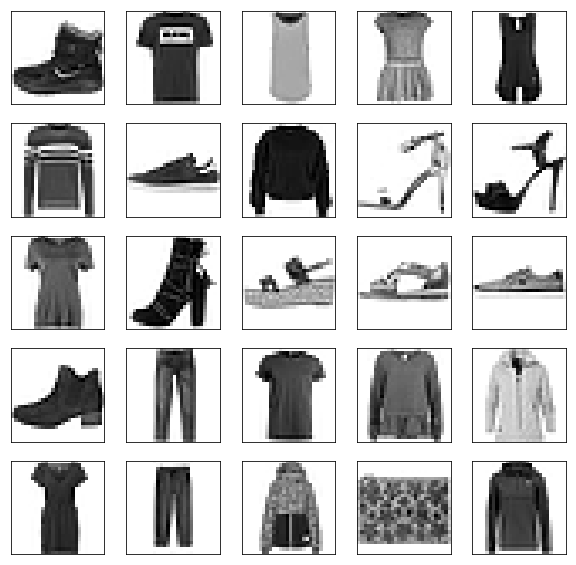

In [3]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap = plt.cm.binary)
plt.show()

In [7]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [18]:
num_features = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape = [num_features]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, (5, 5), (2, 2), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, (5, 5), (2, 2), padding='same', activation='tanh')
])

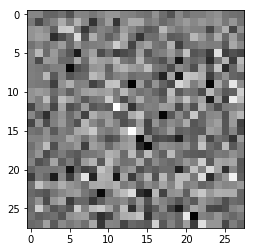

In [33]:
noise = tf.random.normal(shape=[1, num_features])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0,:,:,0], cmap='gray')

In [30]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, (5, 5), (2, 2), padding='same', input_shape = [28, 28, 1]),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Conv2D(128, (5, 5), (2, 2), padding='same'),
    keras.layers.LeakyReLU(0.2),
    keras.layers.Dropout(0.3),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation='sigmoid')
])

In [34]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.500439]], shape=(1, 1), dtype=float32)


In [35]:
discriminator.compile(loss='binary_crossentropy', optimizer='rmsprop')
discriminator.trainable = False
gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss='binary_crossentropy', optimizer='rmsprop')

In [36]:
seed = tf.random.normal(shape=[batch_size, 100])

In [38]:
def train_gan(gan, dataset, batch_size, num_features, epochs = 5):
    gen, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print('Epochs: {}/{}'.format(epoch + 1, epochs))
        for X_batch in dataset:
            noise = tf.random.normal(shape = [batch_size, num_features])
            generated_image = generator(noise)
            X_fake_and_real = tf.concat([generated_image, X_batch], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

In [37]:
## Source https://www.tensorflow.org/tutorials/generative/dcgan#create_a_gif
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    fig = plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='binary')
        plt.axis('off')
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [39]:
x_train_gan = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [40]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(x_train_gan).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1)

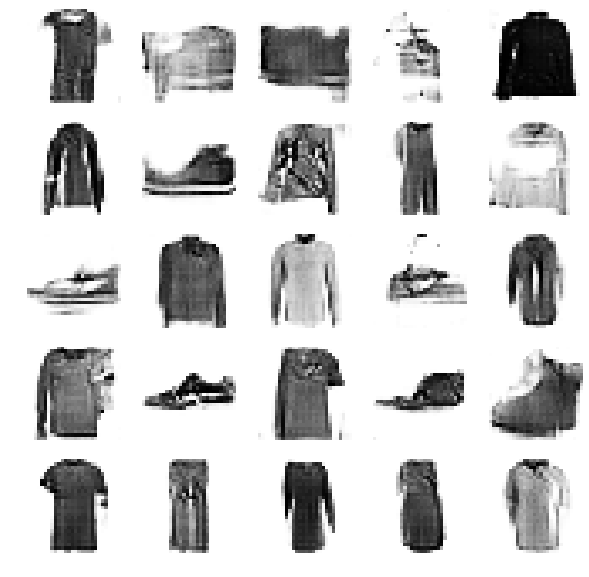

CPU times: user 1h 38min 12s, sys: 1min 57s, total: 1h 40min 10s
Wall time: 31min 22s


In [42]:
%%time
train_gan(gan, dataset, batch_size, num_features, epochs=5)

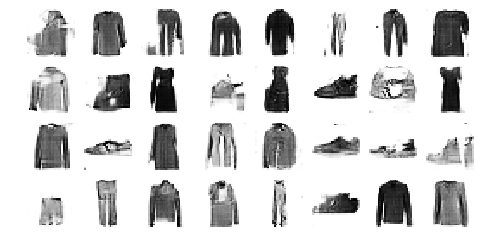

In [47]:
def show(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")


noise = tf.random.normal(shape=[batch_size, num_features])
generated_image = generator(noise)
show(generated_image, 8)